# Excess Heat Factor 85th percentile (EHF85)
# Note that EHF periods have not been processed according to the NPCP tasks (some of the plots will not make sense); the periods need to be adjusted once data for the correct periods ecomes available!

Assessment of model EHF85

In [44]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cmocean
import cartopy.crs as ccrs
import xarray as xr
sys.path.append('/g/data/xv83/users/at2708/bias_adjustment/evaluation/npcp/results')
import utils


In [45]:
# Data collection and processing
def get_data(gcm, rcm, task, index):
    """Get processed EHF data"""
    tasks={
        "historical":{
            "start_date": "19910101",
            "end_date": "20191231",
            "start_date_train": "19910101",
            "end_date_train": "20191231"
        },
        "xvalidation":{
            "start_date": "19910101",
            "end_date": "20191231",
            "start_date_train": "19910101",
            "end_date_train": "20191231"
        },
        "projection":{
            "start_date": "20710101",
            "end_date": "20991231",
            "start_date_train": "19910101",
            "end_date_train": "20191231"
        },
        "agcd_training":{
            "start_date": "19910101",
            "end_date": "20191231",
        }
    }
    assert gcm in ['CSIRO-ACCESS-ESM1-5']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    assert task in ['historical', 'xvalidation']

    da_dict = {}
        
    base_dir = '/g/data/mn51/projects/work_package_4/climate_hazard_indices/heat/EHF/test-data/NPCP/NPCP-20i/'
       
    if task == 'historical' or task == 'xvalidation':  
        # AGCD
        path = base_dir+'observations/AGCD/raw/task-reference/'+index+'_observations_historical_AGCD_raw_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'.nc'
        da_dict['agcd'] = xr.open_dataset(path)['EHF'] 
        
    if task == 'xvalidation':
        # AGCD training 
        path = base_dir+'observations/AGCD/raw/task-reference/'+index+'_observations_historical_AGCD_raw_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'.nc'
        da_dict['agcd_training'] = xr.open_dataset(path)['EHF']  
        
    if task == 'projection' or task == 'xvalidation':  
        # qdc GCM 
        path = base_dir+gcm+'/'+'GCM/qdc/task-'+task+'/'+index+'_'+gcm+'_ssp370_GCM_qdc_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'.nc'
        da_dict['gcm_qdc'] = xr.open_dataset(path)['EHF'] 
        
        # qdc RCMs
        path = base_dir+gcm+'/'+rcm+'/qdc/task-'+task+'/'+index+'_'+gcm+'_ssp370_'+rcm+'_qdc_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'.nc'
        da_dict['rcm_qdc'] = xr.open_dataset(path)['EHF'] 

    # GCM raw
    path = base_dir+gcm+'/'+'GCM/raw/task-reference/'+index+'_'+gcm+'_ssp370_GCM_raw_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'.nc'
    da_dict['gcm_raw'] = xr.open_dataset(path)['EHF'] 
    
    # RCM raw
    path = base_dir+gcm+'/'+rcm+'/raw/task-reference/'+index+'_'+gcm+'_ssp370_'+rcm+'_raw_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'.nc'
    da_dict['rcm_raw'] = xr.open_dataset(path)['EHF'] 

    # ECDFM GCM 
    path = base_dir+gcm+'/'+'GCM/ecdfm/task-'+task+'/'+index+'_'+gcm+'_ssp370_GCM_ecdfm_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'.nc'
    da_dict['gcm_ecdfm'] = xr.open_dataset(path)['EHF'] 
    
    # ECDFM RCMs
    path = base_dir+gcm+'/'+rcm+'/ecdfm/task-'+task+'/'+index+'_'+gcm+'_ssp370_'+rcm+'_ecdfm_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'.nc'
    da_dict['rcm_ecdfm'] = xr.open_dataset(path)['EHF'] 
    
    # QME RCMs
    path = path = base_dir+gcm+'/'+rcm+'/qme/task-'+task+'/'+index+'_'+gcm+'_ssp370_'+rcm+'_qme_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'.nc'
    da_dict['rcm_qme'] = xr.open_dataset(path)['EHF'] 
    lats = np.round(np.arange(-44, -9.9, 0.2), decimals=1)
    if np.allclose(da_dict['rcm_qme']['lat'].values, lats, rtol=1e-05, atol=1e-08, equal_nan=True):
        lat_attrs = da_dict['rcm_qme']['lat'].attrs
        da_dict['rcm_qme'] = da_dict['rcm_qme'].assign_coords({'lat': lats})
        da_dict['rcm_qme'].attrs = lat_attrs
    lons = np.round(np.arange(112, 154.01, 0.2), decimals=1)
    if np.allclose(da_dict['rcm_qme']['lon'].values, lons, rtol=1e-05, atol=1e-08, equal_nan=True):
        lon_attrs = da_dict['rcm_qme']['lon'].attrs
        da_dict['rcm_qme'] = da_dict['rcm_qme'].assign_coords({'lon': lons})
        da_dict['rcm_qme'].attrs = lon_attrs

    return da_dict


In [46]:
# Plotting values
def plot_metric(ax, da, cmap, levels, index, model_name, ob_fractions=None):
    """Plot the PT index for a particular model"""
    data = da
    data = utils.clip_data(data, utils.get_aus_shape())
    if ob_fractions is not None:
        data = utils.mask_by_pr_ob_fraction(data, ob_fractions, threshold=0.9)    

    data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both',
        cbar_kwargs={'label': index},
    )
    ax.set_title(model_name)
    ax.coastlines()


def plot_values(gcm, rcm, task, index, cmap, levels, outfile=None):
    
    da_dict = get_data(gcm, rcm, task, index)

    """Plot the index for each model/method"""

    ncols = 5 if task == 'xvalidation' else 4
    plot_nums = np.arange(1, (ncols * 2) + 1)
    

    ob_fractions = None
    
    fig = plt.figure(figsize=[7 * ncols, 10])
    
    # GCM bias indexection
    plot_index = 0
    ax_gcm1 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_metric(
        ax_gcm1, da_dict['gcm_raw'], cmap, levels, index, gcm, ob_fractions=ob_fractions,
    )
    plot_index = plot_index + 1
    ax_gcm2 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_metric(
        ax_gcm2,  da_dict['gcm_ecdfm'], cmap, levels, index, f'{gcm} (ecdfm)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1   # blank space

    if task == 'xvalidation':
        plot_index = plot_index + 1
        ax_gcm4 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_metric(
            ax_gcm4, da_dict['gcm_qdc'],  cmap, levels, index, f'{gcm} (qdc)', ob_fractions=ob_fractions,
        )

    plot_index = plot_index + 1
    ax_obs = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_metric(ax_obs, da_dict['agcd'], cmap, levels, index, 'AGCD', ob_fractions=ob_fractions)
        
    # RCM bias indexection
    plot_index = plot_index + 1
    ax_rcm1 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_metric(
        ax_rcm1, da_dict['rcm_raw'], cmap, levels, index, f'{rcm} (raw)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1
    ax_rcm2 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_metric(
        ax_rcm2, da_dict['rcm_ecdfm'], cmap, levels, index, f'{rcm} (ecdfm)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1
    ax_rcm3 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_metric(
        ax_rcm3, da_dict['rcm_qme'], cmap, levels, index, f'{rcm} (qme)', ob_fractions=ob_fractions,
    )
    if task == 'xvalidation':
        plot_index = plot_index + 1
        ax_rcm4 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_metric(
            ax_rcm4, da_dict['rcm_qdc'], cmap, levels, index, f'{rcm} (qdc)', ob_fractions=ob_fractions,
        )

        plot_index = plot_index + 1
        ax_rcm5 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_metric(
            ax_rcm5, da_dict['agcd_training'], cmap, levels, index, f'AGCD (training data)', ob_fractions=ob_fractions,
        )
        

    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1991' if task == 'xvalidation' else '1991'
    
    plt.suptitle(f'Annual mean {start_year}-2019 '+index, fontsize='x-large')
    if outfile:
        print(outfile)
        plt.savefig(outfile+f'{index}-values_task-{task}_{gcm}_{rcm}.png', dpi=300, bbox_inches='tight')
    plt.show()


In [47]:
# Plotting bias
def plot_bias(ax, da_obs, da_model, cmap, levels, index, model_name, ob_fractions=None):
    """Plot the bias for a particular model"""
    index_model = da_model
    index_obs = da_obs
    
    bias = index_model - index_obs
    bias = utils.clip_data(bias, utils.get_aus_shape())
    if ob_fractions is not None:
        bias = utils.mask_by_pr_ob_fraction(bias, ob_fractions, threshold=0.9)    
    mae = np.nanmean(np.abs(bias)) 

    bias.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both',
        cbar_kwargs={'label': index},
    )
    ax.text(0.02, 0.02, f'MAE: {mae:.2f}', transform=ax.transAxes, fontsize='large')
    ax.set_title(model_name)
    ax.coastlines()
    
def plot_comparison(gcm, rcm, task, index, cmap, levels, outfile=None):
    """Plot the complete comparison"""

    da_dict = get_data(gcm, rcm, task, index)

    ncols = 5 if task == 'xvalidation' else 3
    plot_nums = np.arange(1, (ncols * 2) + 1)
    
    ob_fractions = None   
    
    fig = plt.figure(figsize=[7 * ncols, 10])
    
    # GCM bias correction
    plot_index = 0
    ax_gcm1 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_bias(
        ax_gcm1, da_dict['agcd'], da_dict['gcm_raw'], cmap, levels, index, gcm, ob_fractions=ob_fractions,
    )
    plot_index = plot_index + 1
    ax_gcm2 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_bias(
        ax_gcm2, da_dict['agcd'], da_dict['gcm_ecdfm'], cmap, levels, index, f'{gcm} (ecdfm)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1   # blank space

    if task == 'xvalidation':
        plot_index = plot_index + 1
        ax_gcm4 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_bias(
            ax_gcm4, da_dict['agcd'],da_dict['gcm_qdc'], cmap, levels, index, f'{gcm} (qdc)', ob_fractions=ob_fractions,
        )
        plot_index = plot_index + 1

    # RCM bias correction
    plot_index = plot_index + 1
    ax_rcm1 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_bias(
        ax_rcm1, da_dict['agcd'],  da_dict['rcm_raw'], cmap, levels, index, f'{rcm} (raw)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1
    ax_rcm2 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_bias(
        ax_rcm2, da_dict['agcd'], da_dict['rcm_ecdfm'], cmap, levels, index, f'{rcm} (ecdfm)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1
    ax_rcm3 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_bias(
        ax_rcm3, da_dict['agcd'], da_dict['rcm_qme'], cmap, levels, index, f'{rcm} (qme)', ob_fractions=ob_fractions,
    )
    if task == 'xvalidation':
        plot_index = plot_index + 1
        ax_rcm4 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_bias(
            ax_rcm4, da_dict['agcd'], da_dict['rcm_qdc'], cmap, levels, index, f'{rcm} (qdc)', ob_fractions=ob_fractions,
        )
        
        plot_index = plot_index + 1
        ax_rcm5 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_bias(
            ax_rcm5, da_dict['agcd'], da_dict['agcd_training'], cmap, levels, index, f'AGCD (training data)', ob_fractions=ob_fractions,
        )
        

    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1991' if task == 'xvalidation' else '1991'
    
    plt.suptitle(f'Bias (model minus obs) in the annual mean {start_year}-2019 '+index, fontsize='x-large')
    if outfile:
        print(outfile)
        plt.savefig(outfile+f'{index}-bias_task-{task}_{gcm}_{rcm}.png', dpi=300, bbox_inches='tight')
    plt.show()

## task-historical

Bias corrected data for the 1980-2019 period, using 1980-2019 as a training period.

#### ERA5

In [48]:
#gcm = 'ECMWF-ERA5'
#task = 'historical'
# index = 'WSDI'

In [49]:
#rcm = 'BOM-BARPA-R'
# plot_values()
# plot_comparison()

In [50]:
#rcm = 'CSIRO-CCAM-2203'
# plot_values()
# plot_comparison()

In [51]:
#rcm = 'UQ-DES-CCAM-2105'
# plot_values()
# plot_comparison()

#### ACCESS-ESM1-5

In [52]:
gcm = 'CSIRO-ACCESS-ESM1-5'
task = 'historical'
rcm = 'BOM-BARPA-R'
index = 'EHF85'
levels_values=[0,5,10,15,20,25,30,35]
cmap_values='Reds'
levels_bias=[-5,-4,-3,-2,-1,1,2,3,4,5]
cmap_bias='RdBu_r'
outfile='/g/data/xv83/users/at2708/bias_adjustment/evaluation/'

/g/data/xv83/users/at2708/bias_adjustment/evaluation/


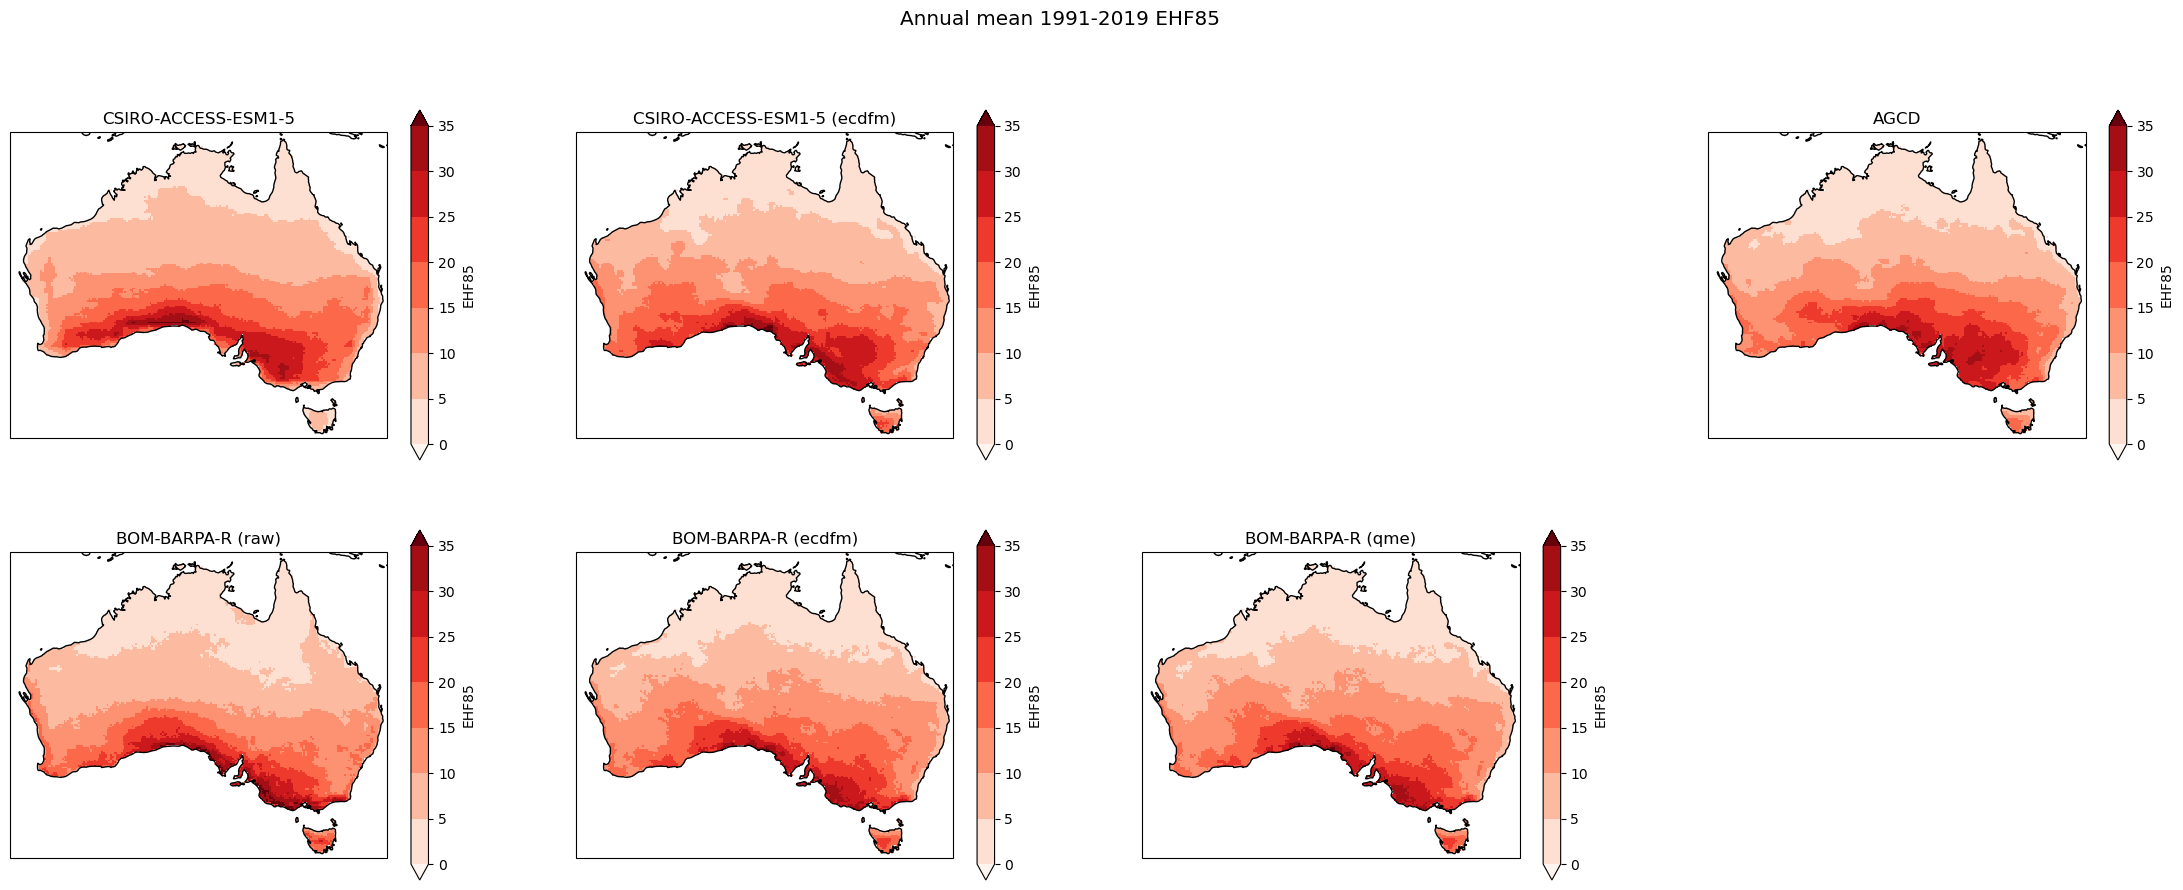

In [53]:
plot_values(gcm, rcm, task, index, cmap=cmap_values, levels=levels_values, outfile=outfile)

/g/data/xv83/users/at2708/bias_adjustment/evaluation/


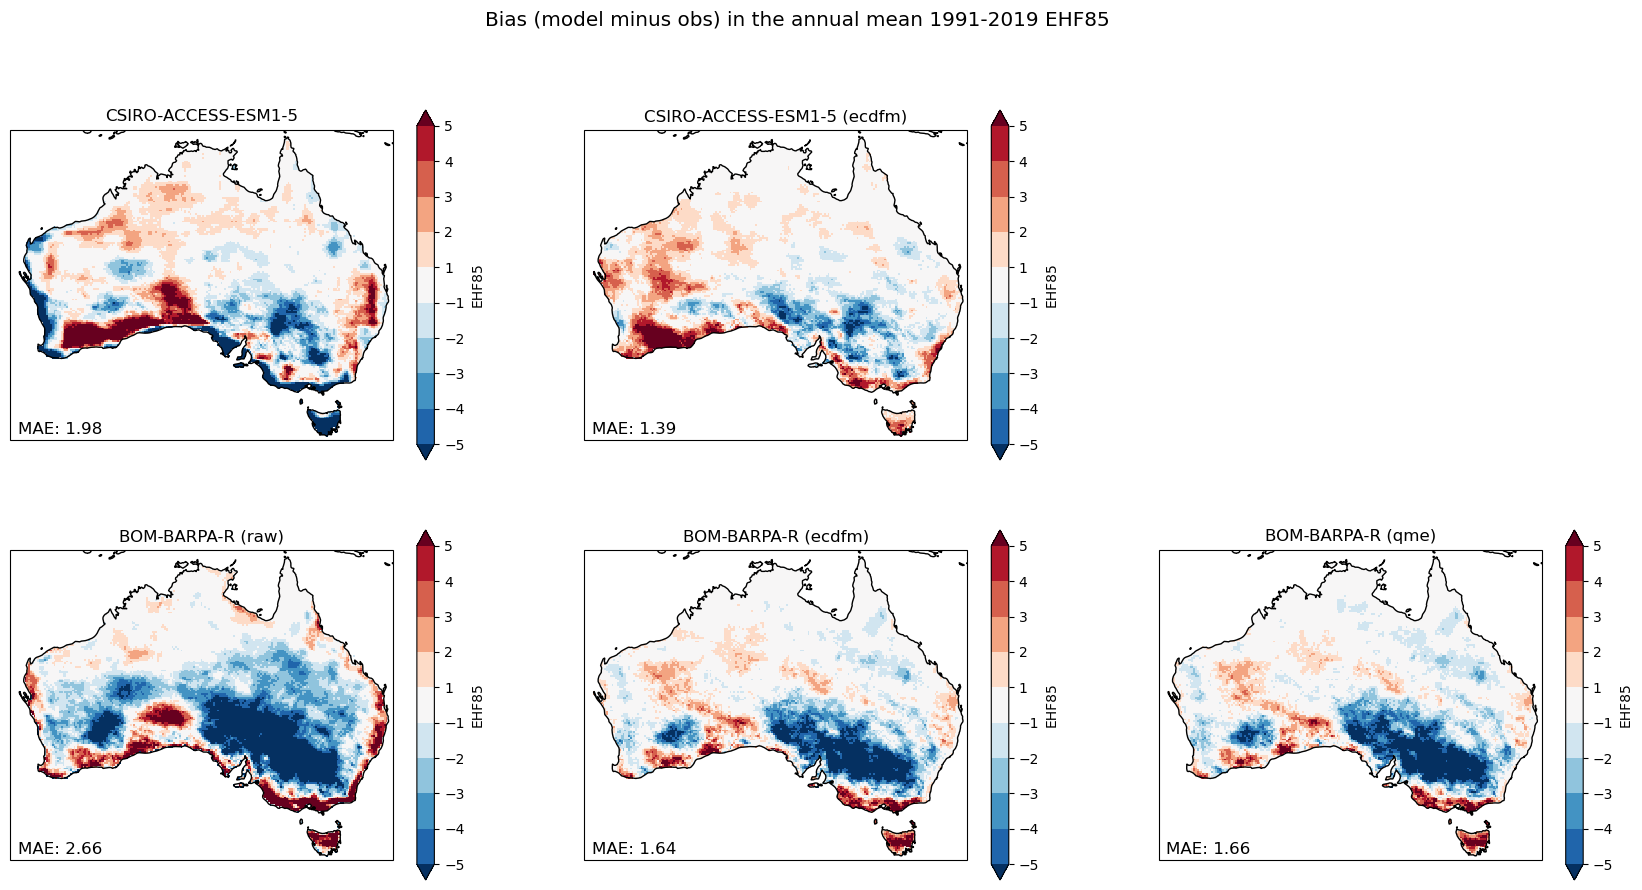

In [54]:
plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias, outfile=outfile)

In [ ]:
rcm = 'CSIRO-CCAM-2203'
plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias)

In [ ]:
rcm = 'UQ-DES-CCAM-2105'
plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias)

## task-xvalidation

#### ERA5

Bias corrected data for the 2000-2019 period, using 1980-1999 as a training period.

In [ ]:
#gcm = 'ECMWF-ERA5'
#task = 'xvalidation'

In [ ]:
#rcm = 'BOM-BARPA-R'
# plot_values()
# plot_comparison()

In [ ]:
#rcm = 'CSIRO-CCAM-2203'
# plot_values()
# plot_comparison()

In [ ]:
#rcm = 'UQ-DES-CCAM-2105'
# plot_values()
# plot_comparison()

#### ACCESS-ESM1-5

Bias corrected data for the 1990-2019 period, using 1960-1989 as a training period.

In [55]:
gcm = 'CSIRO-ACCESS-ESM1-5'
task = 'xvalidation'
rcm = 'BOM-BARPA-R'

/g/data/xv83/users/at2708/bias_adjustment/evaluation/


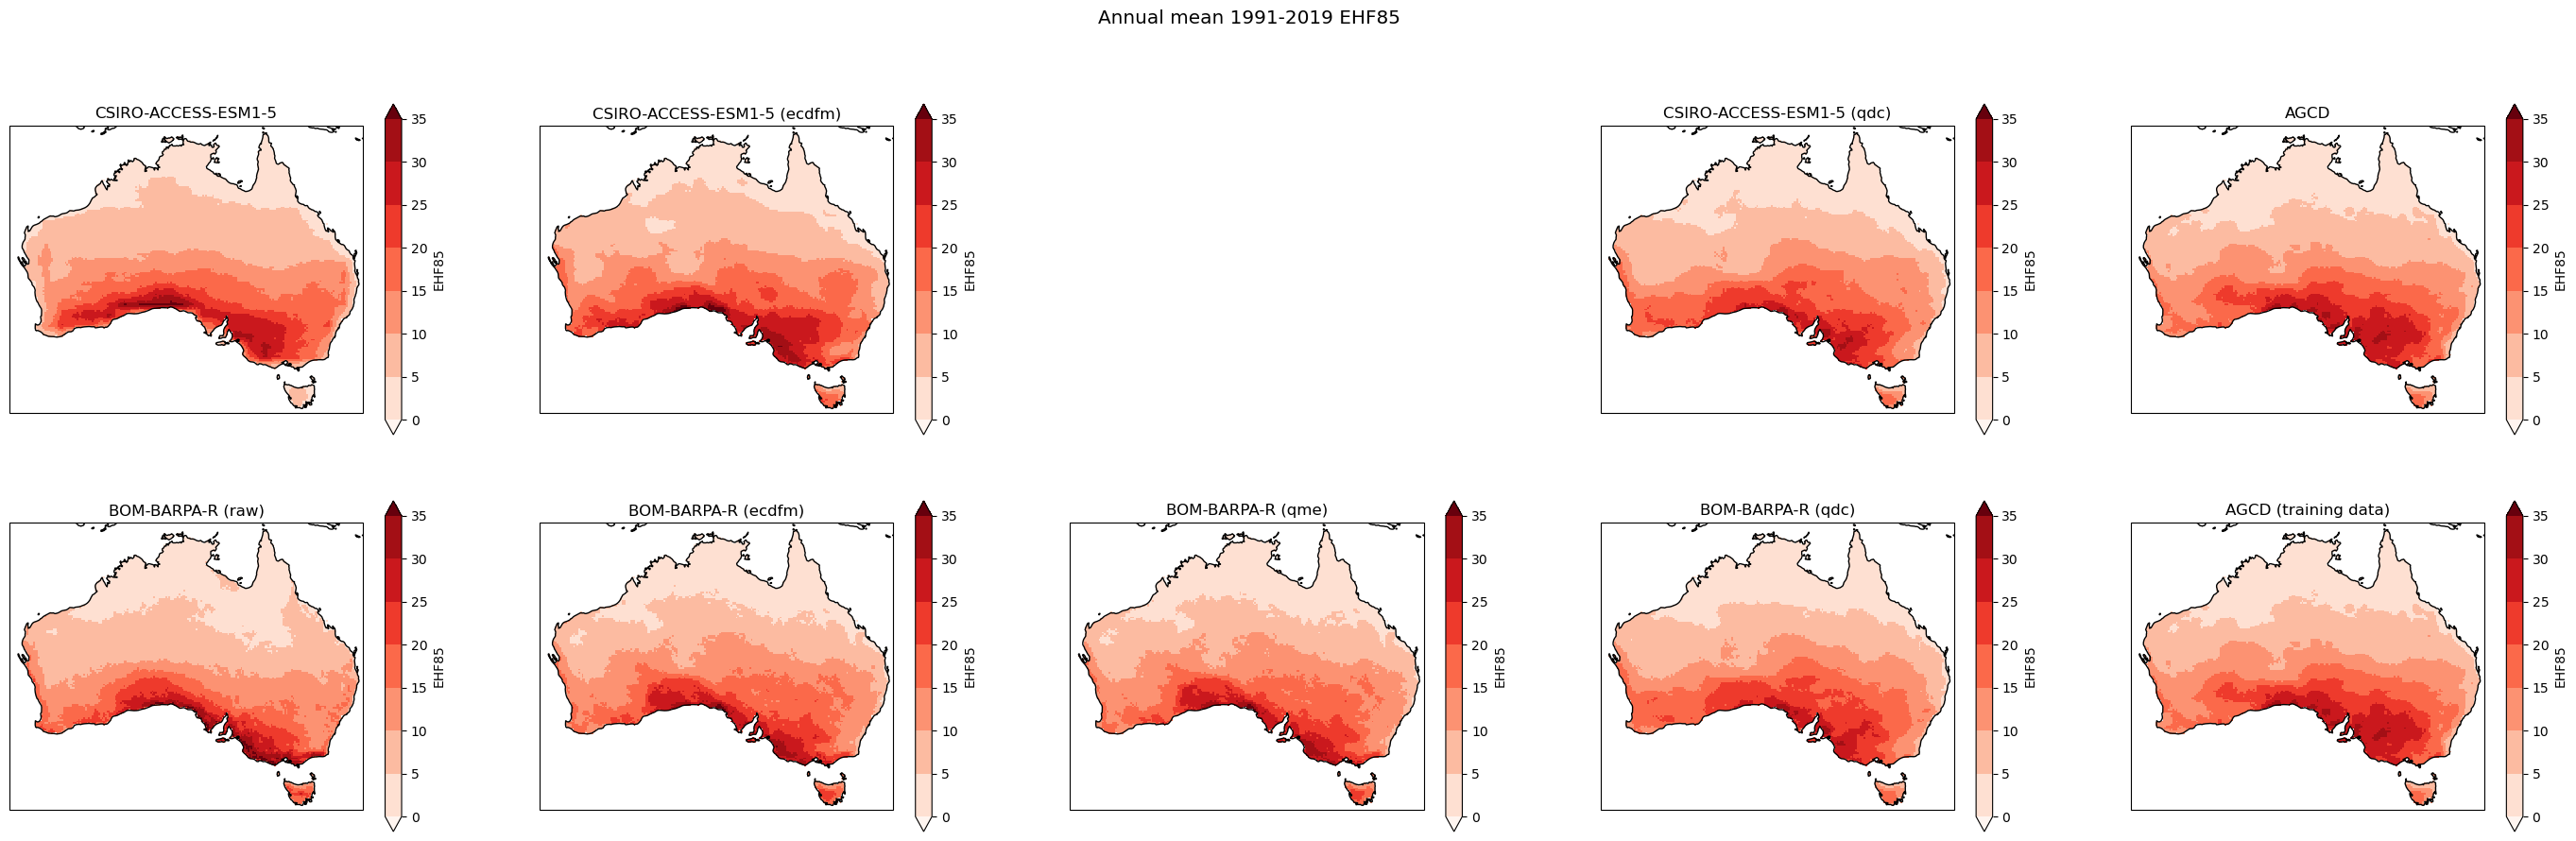

In [56]:
plot_values(gcm, rcm, task, index, cmap=cmap_values, levels=levels_values, outfile=outfile)

/g/data/xv83/users/at2708/bias_adjustment/evaluation/


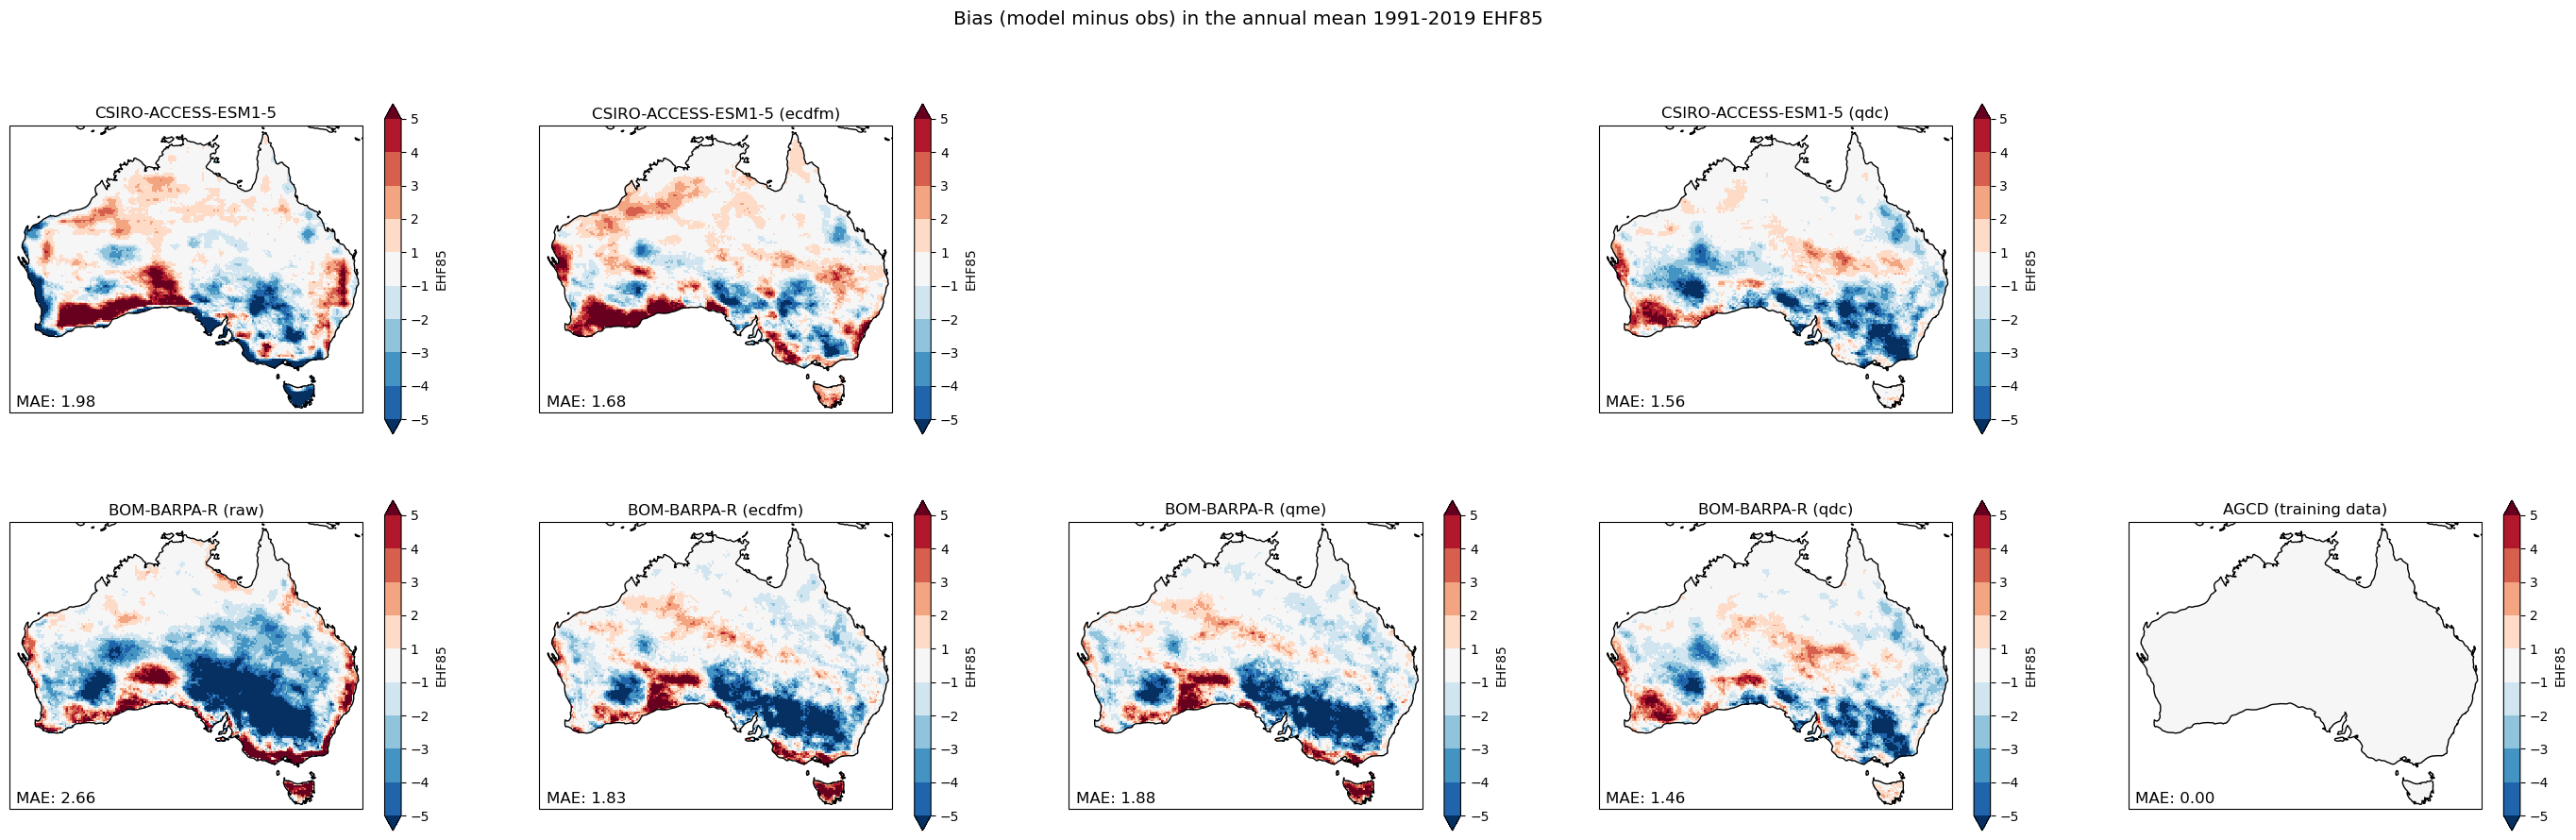

In [57]:
plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias, outfile=outfile)

In [ ]:
rcm = 'CSIRO-CCAM-2203'
plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias)

In [ ]:
rcm = 'UQ-DES-CCAM-2105'
plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias)